# Forecast a time series with a uncertainties 

This is a hello world for forecasts predictions for time series with uncertainties.

Besides the central value, predict also a confidence interval around it.

Implementing the example from [Medium](https://towardsdatascience.com/conformal-predictions-in-time-series-forecasting-32d3243d7479#:~:text=They%20are%20applied%20across%20various,point%20will%20lie%20inside%20it) using the EnbPI algorithm, described on this [paper](https://arxiv.org/pdf/2010.09107.pdf), and implemented in the [MAPIE](https://mapie.readthedocs.io/en/latest/) python library. 

The dataset is from [here](https://github.com/marcopeix/time-series-analysis/blob/master/data/medium_views_published_holidays.csv). The original code is in [Github](https://github.com/marcopeix/time-series-analysis/tree/master) but I reorganise and personalize in my style, adding nuances to it.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import time

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# mapie for confidence intervals around predictions of time-series forecasts
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor

In [2]:
df = pd.read_csv('data/medium_views_published_holidays.csv')
df

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0
...,...,...,...,...,...
1376,0,2023-10-08,737,0.0,0
1377,0,2023-10-09,1237,0.0,1
1378,0,2023-10-10,1755,1.0,0
1379,0,2023-10-11,3241,0.0,0


In [4]:
df = df.drop(['unique_id'], axis=1)
df

,ds,y,published,is_holiday
0,2020-01-01,1131,0.0,1
1,2020-01-02,1764,0.0,0
2,2020-01-03,1699,0.0,0
3,2020-01-04,1322,0.0,0
4,2020-01-05,1491,0.0,0
...,...,...,...,...
1376,2023-10-08,737,0.0,0
1377,2023-10-09,1237,0.0,1
1378,2023-10-10,1755,1.0,0
1379,2023-10-11,3241,0.0,0


In [5]:
df.dtypes

ds             object
y               int64
published     float64
is_holiday      int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ds          1381 non-null   object 
 1   y           1381 non-null   int64  
 2   published   1381 non-null   float64
 3   is_holiday  1381 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 43.3+ KB


# Time series data exploration

In [9]:
df["datetime"] = pd.to_datetime(df["ds"])
df = df.drop("ds", axis=1)
df

,y,published,is_holiday,datetime
0,1131,0.0,1,2020-01-01
1,1764,0.0,0,2020-01-02
2,1699,0.0,0,2020-01-03
3,1322,0.0,0,2020-01-04
4,1491,0.0,0,2020-01-05
...,...,...,...,...
1376,737,0.0,0,2023-10-08
1377,1237,0.0,1,2023-10-09
1378,1755,1.0,0,2023-10-10
1379,3241,0.0,0,2023-10-11


In [11]:
# Extract year, month and day
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

# Add a flag for weekend days
df['is_weekend'] = (df['datetime'].dt.dayofweek >= 5).astype(int)
df

,y,published,is_holiday,datetime,year,month,day,is_weekend
0,1131,0.0,1,2020-01-01,2020,1,1,0
1,1764,0.0,0,2020-01-02,2020,1,2,0
2,1699,0.0,0,2020-01-03,2020,1,3,0
3,1322,0.0,0,2020-01-04,2020,1,4,1
4,1491,0.0,0,2020-01-05,2020,1,5,1
...,...,...,...,...,...,...,...,...
1376,737,0.0,0,2023-10-08,2023,10,8,1
1377,1237,0.0,1,2023-10-09,2023,10,9,0
1378,1755,1.0,0,2023-10-10,2023,10,10,0
1379,3241,0.0,0,2023-10-11,2023,10,11,0


In [12]:
# Add lagged values for the past 7 days
for day in range(1, 8):
    df[f'lag_{day}'] = df['y'].shift(day)
df

,y,published,is_holiday,datetime,year,month,day,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,1131,0.0,1,2020-01-01,2020,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1764,0.0,0,2020-01-02,2020,1,2,0,1131.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1699,0.0,0,2020-01-03,2020,1,3,0,1764.0,1131.0,NaN,NaN,NaN,NaN,NaN
3,1322,0.0,0,2020-01-04,2020,1,4,1,1699.0,1764.0,1131.0,NaN,NaN,NaN,NaN
4,1491,0.0,0,2020-01-05,2020,1,5,1,1322.0,1699.0,1764.0,1131.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,737,0.0,0,2023-10-08,2023,10,8,1,583.0,1030.0,1037.0,1136.0,1221.0,1176.0,665.0
1377,1237,0.0,1,2023-10-09,2023,10,9,0,737.0,583.0,1030.0,1037.0,1136.0,1221.0,1176.0
1378,1755,1.0,0,2023-10-10,2023,10,10,0,1237.0,737.0,583.0,1030.0,1037.0,1136.0,1221.0
1379,3241,0.0,0,2023-10-11,2023,10,11,0,1755.0,1237.0,737.0,583.0,1030.0,1037.0,1136.0


In [13]:
df = df.set_index("datetime")
df

,y,published,is_holiday,year,month,day,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,,
2020-01-01,1131,0.0,1,2020,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,1764,0.0,0,2020,1,2,0,1131.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1699,0.0,0,2020,1,3,0,1764.0,1131.0,NaN,NaN,NaN,NaN,NaN
2020-01-04,1322,0.0,0,2020,1,4,1,1699.0,1764.0,1131.0,NaN,NaN,NaN,NaN
2020-01-05,1491,0.0,0,2020,1,5,1,1322.0,1699.0,1764.0,1131.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-08,737,0.0,0,2023,10,8,1,583.0,1030.0,1037.0,1136.0,1221.0,1176.0,665.0
2023-10-09,1237,0.0,1,2023,10,9,0,737.0,583.0,1030.0,1037.0,1136.0,1221.0,1176.0
2023-10-10,1755,1.0,0,2023,10,10,0,1237.0,737.0,583.0,1030.0,1037.0,1136.0,1221.0


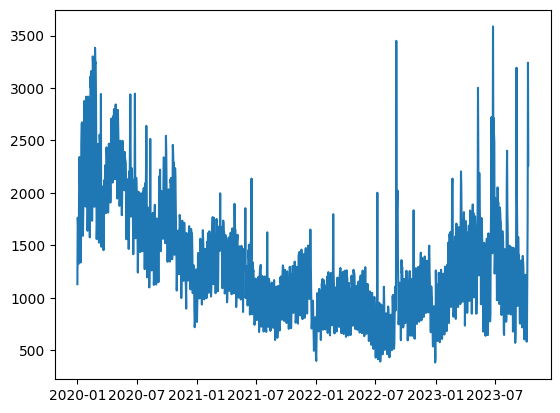

In [14]:
plt.plot(df["y"])

In [25]:
def plot_overlay_time_series(df, ylim, values):
    # Set the figure size and create the plot
    fig, ax = plt.subplots(figsize=(40, 10))

    x = df.index

    # Set the tick locations and labels on the x-axis
    format = "%Y-%m-%d"
    date_form = matplotlib.dates.DateFormatter(format)
    ax.xaxis.set_major_formatter(date_form)
    ax.tick_params(axis="x", labelsize=24)
    plt.xticks(rotation=90)

    for name, color in values:
        plt.plot(x, df[name], color=color, marker="o")

    plt.ylim(ylim)
    return fig

    # Show the plot
    # plt.show()

    # plt.close()

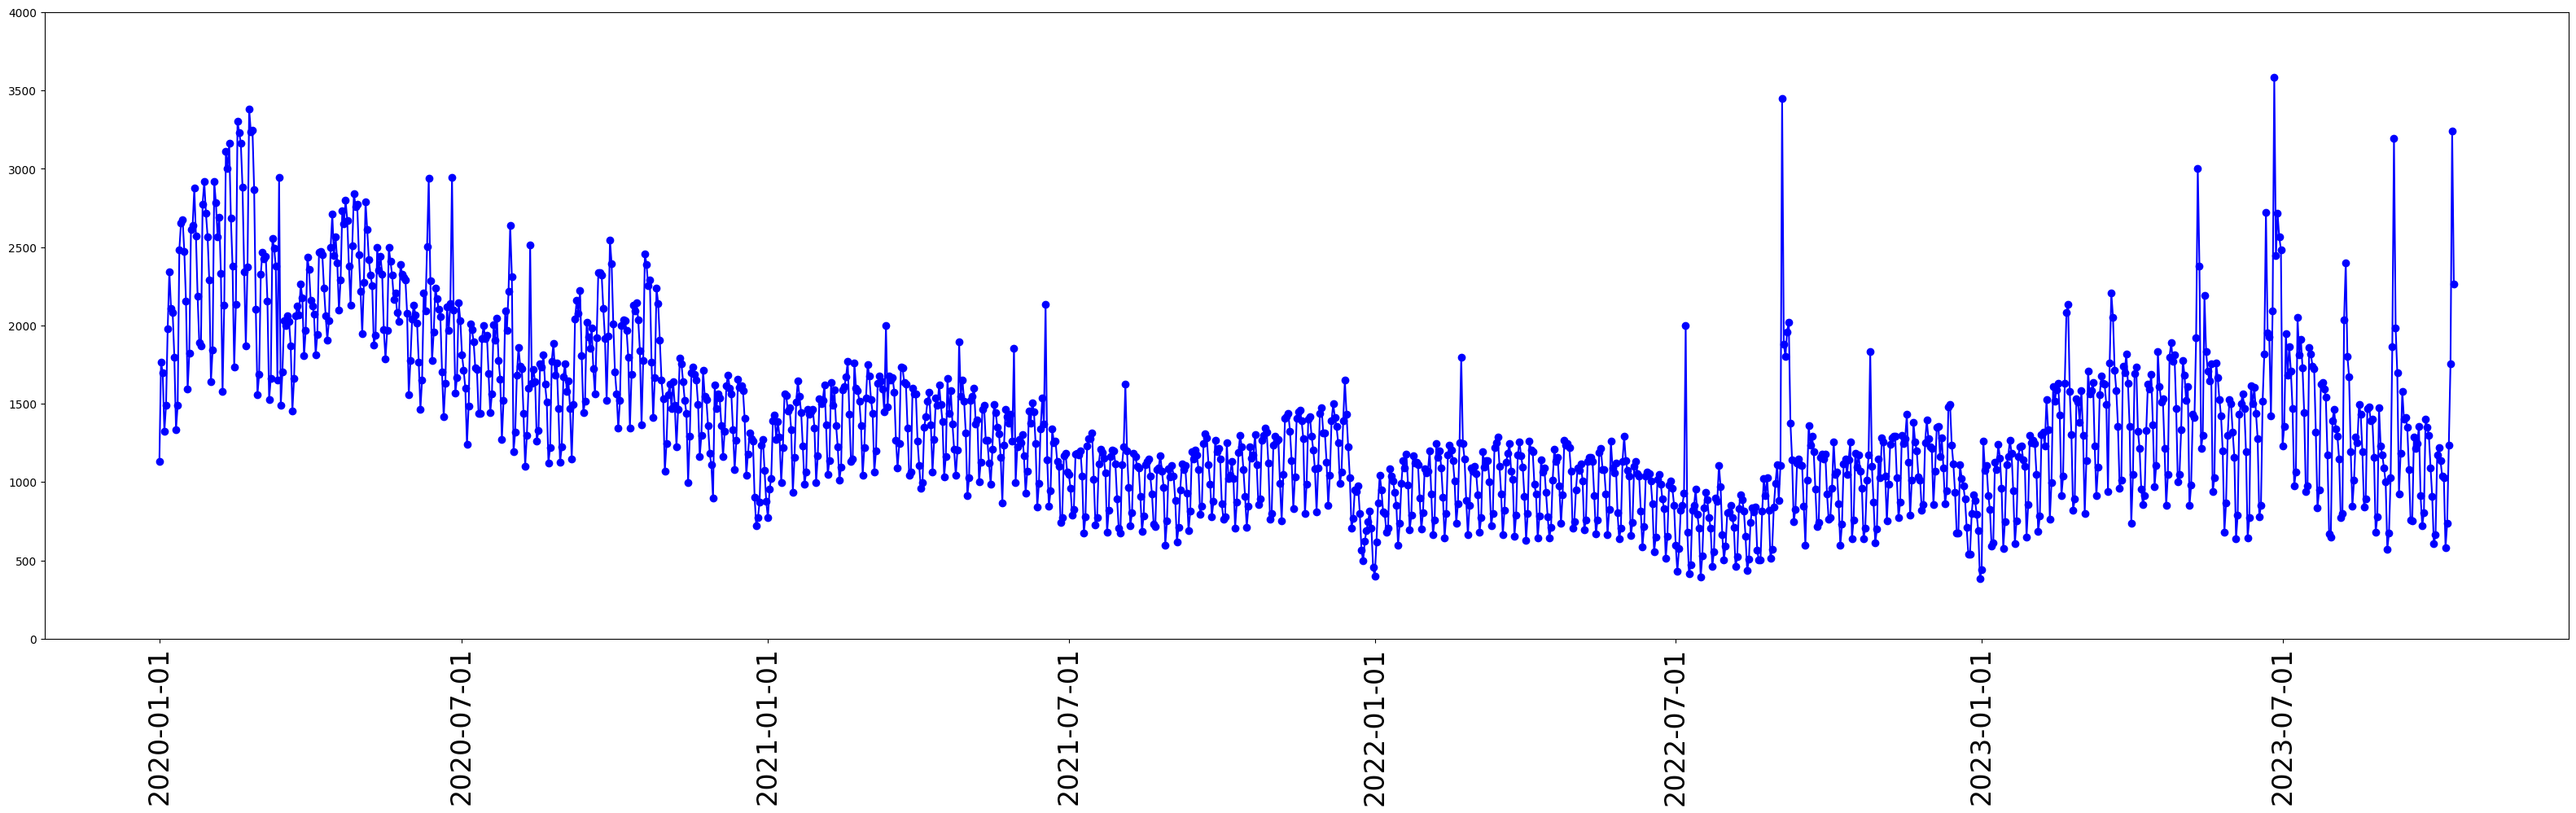

In [27]:
fig = plot_overlay_time_series(df, (0, 4000), [
    ("y", "blue"),
])

# Divide in train and test

Test must be after train. 

There are 3 years of data, keey 16 weeks in test.

In [28]:
test_size = 4*4*7
test_size

112

In [29]:
X = df.drop("y", axis=1)
X

,published,is_holiday,year,month,day,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,
2020-01-01,0.0,1,2020,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,0.0,0,2020,1,2,0,1131.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.0,0,2020,1,3,0,1764.0,1131.0,NaN,NaN,NaN,NaN,NaN
2020-01-04,0.0,0,2020,1,4,1,1699.0,1764.0,1131.0,NaN,NaN,NaN,NaN
2020-01-05,0.0,0,2020,1,5,1,1322.0,1699.0,1764.0,1131.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-08,0.0,0,2023,10,8,1,583.0,1030.0,1037.0,1136.0,1221.0,1176.0,665.0
2023-10-09,0.0,1,2023,10,9,0,737.0,583.0,1030.0,1037.0,1136.0,1221.0,1176.0
2023-10-10,1.0,0,2023,10,10,0,1237.0,737.0,583.0,1030.0,1037.0,1136.0,1221.0


In [30]:
y = df["y"]
y

datetime
2020-01-01    1131
2020-01-02    1764
2020-01-03    1699
2020-01-04    1322
2020-01-05    1491
              ... 
2023-10-08     737
2023-10-09    1237
2023-10-10    1755
2023-10-11    3241
2023-10-12    2262
Name: y, Length: 1381, dtype: int64

In [31]:
X_train = X[:-test_size]
X_train

,published,is_holiday,year,month,day,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,
2020-01-01,0.0,1,2020,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,0.0,0,2020,1,2,0,1131.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.0,0,2020,1,3,0,1764.0,1131.0,NaN,NaN,NaN,NaN,NaN
2020-01-04,0.0,0,2020,1,4,1,1699.0,1764.0,1131.0,NaN,NaN,NaN,NaN
2020-01-05,0.0,0,2020,1,5,1,1322.0,1699.0,1764.0,1131.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18,0.0,0,2023,6,18,1,777.0,1280.0,1439.0,1603.0,1499.0,1615.0,772.0
2023-06-19,0.0,1,2023,6,19,0,850.0,777.0,1280.0,1439.0,1603.0,1499.0,1615.0
2023-06-20,1.0,0,2023,6,20,0,1515.0,850.0,777.0,1280.0,1439.0,1603.0,1499.0


In [32]:
X_test = X[-test_size:]
X_test

,published,is_holiday,year,month,day,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,
2023-06-23,0.0,0,2023,6,23,0,1953.0,2722.0,1818.0,1515.0,850.0,777.0,1280.0
2023-06-24,0.0,0,2023,6,24,1,1928.0,1953.0,2722.0,1818.0,1515.0,850.0,777.0
2023-06-25,0.0,0,2023,6,25,1,1425.0,1928.0,1953.0,2722.0,1818.0,1515.0,850.0
2023-06-26,0.0,0,2023,6,26,0,2091.0,1425.0,1928.0,1953.0,2722.0,1818.0,1515.0
2023-06-27,0.0,0,2023,6,27,0,3586.0,2091.0,1425.0,1928.0,1953.0,2722.0,1818.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-08,0.0,0,2023,10,8,1,583.0,1030.0,1037.0,1136.0,1221.0,1176.0,665.0
2023-10-09,0.0,1,2023,10,9,0,737.0,583.0,1030.0,1037.0,1136.0,1221.0,1176.0
2023-10-10,1.0,0,2023,10,10,0,1237.0,737.0,583.0,1030.0,1037.0,1136.0,1221.0


In [33]:
y_train = y[:-test_size]
y_train

datetime
2020-01-01    1131
2020-01-02    1764
2020-01-03    1699
2020-01-04    1322
2020-01-05    1491
              ... 
2023-06-18     850
2023-06-19    1515
2023-06-20    1818
2023-06-21    2722
2023-06-22    1953
Name: y, Length: 1269, dtype: int64

In [34]:
y_test = y[-test_size:]
y_test

datetime
2023-06-23    1928
2023-06-24    1425
2023-06-25    2091
2023-06-26    3586
2023-06-27    2445
              ... 
2023-10-08     737
2023-10-09    1237
2023-10-10    1755
2023-10-11    3241
2023-10-12    2262
Name: y, Length: 112, dtype: int64

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1269, 13), (1269,), (112, 13), (112,))

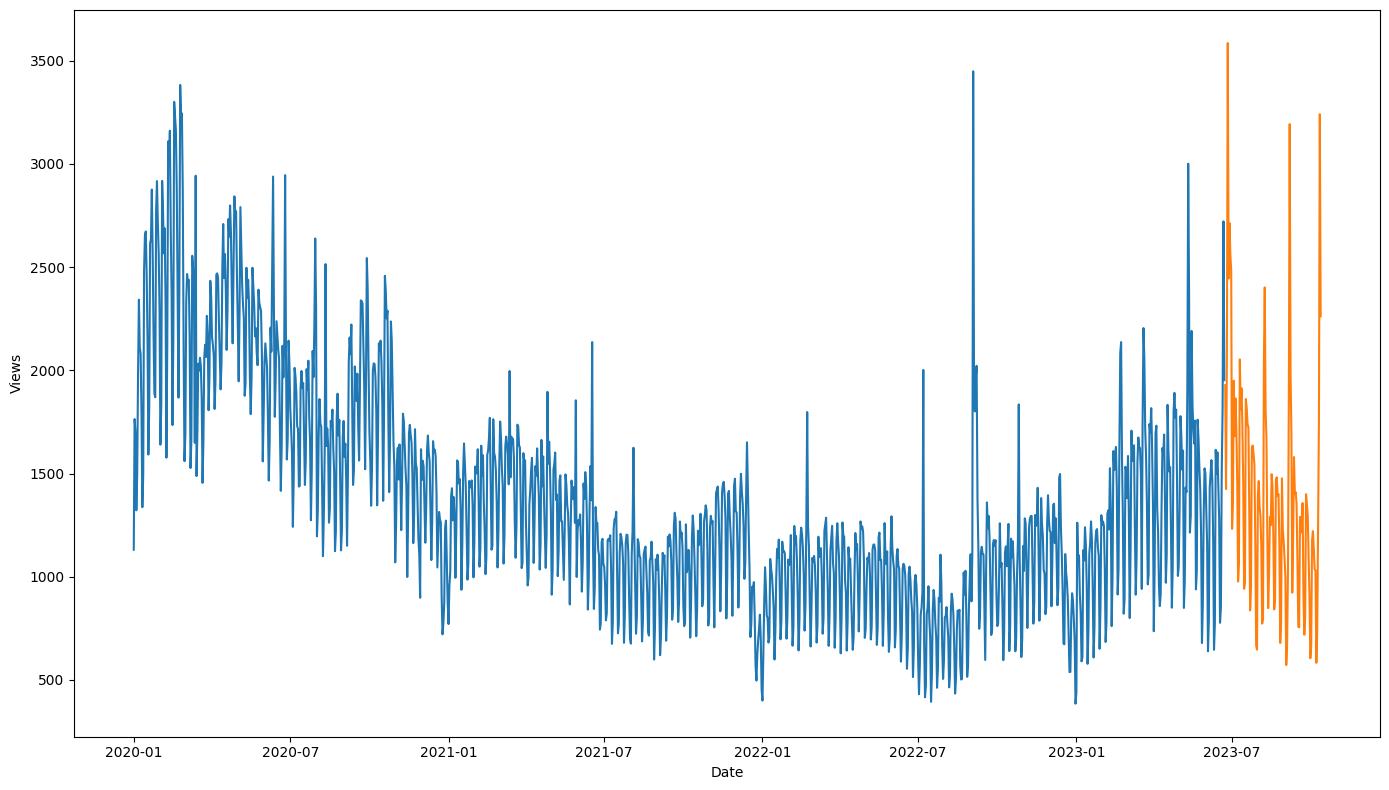

In [37]:
# visualise the train-test split
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_train)
ax.plot(y_test)
ax.set_xlabel('Date')
ax.set_ylabel('Views')
plt.tight_layout()

# Train one model

We choose a Histogram based regressor to take natively care for missing values, which we have for the lag quantities.

We use a hyper-parameter tuning, with a k-fold specific for time series.

In [43]:
# illustrate the splits that are obtained
def illustrate_splits_obtained(df: pd.DataFrame, tscv: TimeSeriesSplit):
    """Illustrate the splits obtained."""
    # split the data frame using this approach and show which indices (dates) are used
    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        print(
            f"i={str(i).zfill(2)}, "
            f"train={train.index.min().date()} to {train.index.max().date()} for {len(train):-3} days, "
            f"test={test.index.min().date()} to {test.index.max().date()} for {len(test)} days,"
        )
        # do something with the train and test sets
        pass

In [91]:
# build a time series cross validation in a walk-forward style, from begging up to a point
wf_ts_cv=TimeSeriesSplit(n_splits=10, max_train_size = None, test_size=4*4*7)
illustrate_splits_obtained(X_train, wf_ts_cv)

i=00, train=2020-01-01 to 2020-05-28 for 149 days, test=2020-05-29 to 2020-09-17 for 112 days,
i=01, train=2020-01-01 to 2020-09-17 for 261 days, test=2020-09-18 to 2021-01-07 for 112 days,
i=02, train=2020-01-01 to 2021-01-07 for 373 days, test=2021-01-08 to 2021-04-29 for 112 days,
i=03, train=2020-01-01 to 2021-04-29 for 485 days, test=2021-04-30 to 2021-08-19 for 112 days,
i=04, train=2020-01-01 to 2021-08-19 for 597 days, test=2021-08-20 to 2021-12-09 for 112 days,
i=05, train=2020-01-01 to 2021-12-09 for 709 days, test=2021-12-10 to 2022-03-31 for 112 days,
i=06, train=2020-01-01 to 2022-03-31 for 821 days, test=2022-04-01 to 2022-07-21 for 112 days,
i=07, train=2020-01-01 to 2022-07-21 for 933 days, test=2022-07-22 to 2022-11-10 for 112 days,
i=08, train=2020-01-01 to 2022-11-10 for 1045 days, test=2022-11-11 to 2023-03-02 for 112 days,
i=09, train=2020-01-01 to 2023-03-02 for 1157 days, test=2023-03-03 to 2023-06-22 for 112 days,


In [92]:
# for reference a rolling window split would be like this
rw_ts_cv=TimeSeriesSplit(n_splits=10, max_train_size = 12*4*7, test_size=4*4*7)
illustrate_splits_obtained(X_train, rw_ts_cv)

i=00, train=2020-01-01 to 2020-05-28 for 149 days, test=2020-05-29 to 2020-09-17 for 112 days,
i=01, train=2020-01-01 to 2020-09-17 for 261 days, test=2020-09-18 to 2021-01-07 for 112 days,
i=02, train=2020-02-07 to 2021-01-07 for 336 days, test=2021-01-08 to 2021-04-29 for 112 days,
i=03, train=2020-05-29 to 2021-04-29 for 336 days, test=2021-04-30 to 2021-08-19 for 112 days,
i=04, train=2020-09-18 to 2021-08-19 for 336 days, test=2021-08-20 to 2021-12-09 for 112 days,
i=05, train=2021-01-08 to 2021-12-09 for 336 days, test=2021-12-10 to 2022-03-31 for 112 days,
i=06, train=2021-04-30 to 2022-03-31 for 336 days, test=2022-04-01 to 2022-07-21 for 112 days,
i=07, train=2021-08-20 to 2022-07-21 for 336 days, test=2022-07-22 to 2022-11-10 for 112 days,
i=08, train=2021-12-10 to 2022-11-10 for 336 days, test=2022-11-11 to 2023-03-02 for 112 days,
i=09, train=2022-04-01 to 2023-03-02 for 336 days, test=2023-03-03 to 2023-06-22 for 112 days,


In [70]:
# the model
hgbr = HistGradientBoostingRegressor(random_state=42)
hgbr

HistGradientBoostingRegressor(random_state=42)

# These are the default values

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
    
class sklearn.ensemble.HistGradientBoostingRegressor(loss='squared_error', *, quantile=None, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_features=1.0, max_bins=255, categorical_features='warn', monotonic_cst=None, interaction_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)[source]¶

In [93]:
# parameters for hyperparameter tuning
params = {
    "loss":  ["squared_error", "absolute_error", "poisson"],
    "learning_rate": [0.3, 0.2, 0.1, 0.05, 0.001],
    "max_iter": [50, 100, 150, 200, 500],
    "min_samples_leaf": [1, 2, 3, 4, 5],
}
params

{'loss': ['squared_error', 'absolute_error', 'poisson'],
 'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.001],
 'max_iter': [50, 100, 150, 200, 500],
 'min_samples_leaf': [1, 2, 3, 4, 5]}

In [95]:
# define the hyper parameter tuning
# use the walk-forward cross validaiton
# the scoring metric will be maximized, hence the negative sign of the mean squared error
rand_search_cv = RandomizedSearchCV(
    hgbr,
    param_distributions=params,
    cv=wf_ts_cv,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=6,
)
rand_search_cv

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=112),
                   estimator=HistGradientBoostingRegressor(random_state=42),
                   n_jobs=6,
                   param_distributions={'learning_rate': [0.3, 0.2, 0.1, 0.05,
                                                          0.001],
                                        'loss': ['squared_error',
                                                 'absolute_error', 'poisson'],
                                        'max_iter': [50, 100, 150, 200, 500],
                                        'min_samples_leaf': [1, 2, 3, 4, 5]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [96]:
# perform the training train the model with hyper-parameter tuning
start = time.time()
rand_search_cv.fit(X_train, y_train)
end = time.time()
duration = end - start
print(f"training duration = {duration:.2f} seconds, {duration/60:.2f} minutes.")

training duration = 21.43 seconds, 0.36 minutes.


In [97]:
# the resulting best model
model = rand_search_cv.best_estimator_
model

HistGradientBoostingRegressor(learning_rate=0.2, loss='absolute_error',
                              max_iter=200, min_samples_leaf=5,
                              random_state=42)

# Estimate prediction intervals with EnbPI method

Once we have an optimized model, we can now build prediction intervals using the EnbPI method.

To apply the EnbPI algorithm, we must use the MapieTimeSeriesRegressor object with BlockBootstrap. Remember that EnbPI fits a fixed number of models on non-overlapping blocks, and BlockBootstrap handles that for us.

Then, to evaluate the quality of our prediction intervals, we use the coverage and mean width score. Coverage reports the percentage of actual values that fall inside the intervals. The mean width score simply reports the average width of confidence intervals.

In an ideal situation, we have the narrowest intervals possible achieving the highest coverage possible.

In [102]:
# training set divisible by 9
y_train.shape[0]/9

141.0

In [103]:
# coverage: For a 95% confidence interval, use alpha=0.05
alpha = 0.05
alpha

0.05

In [104]:
# lookahead will predict next step
# Set the horizon to 1
h = 1

In [106]:
# In the code block above, note that we use n_blocks=9 since the training set is divisible by 9.
# Also, make sure to set overlapping=False as the EnbPI methods requires the blocks to be non-overlapping.
cv_mapie_ts = BlockBootstrap(
    n_resamplings=9,
    n_blocks=9,
    overlapping=False,
    random_state=42
)
cv_mapie_ts

BlockBootstrap(length=None, n_blocks=9, n_resamplings=9, overlapping=False,
        random_state=42)

In [107]:
# Then, the regression model already trained called "model"
# is simply wrapped in the MapieTimeSeriesRegressorobject,
# which we can then fit and use to make predictions.
mapie_enbpi = MapieTimeSeriesRegressor(
    model,
    method='enbpi',
    cv=cv_mapie_ts,
    agg_function='mean',
    n_jobs=5,
)
mapie_enbpi

MapieTimeSeriesRegressor(cv=BlockBootstrap(length=None, n_blocks=9, n_resamplings=9, overlapping=False,
        random_state=42),
                         estimator=HistGradientBoostingRegressor(learning_rate=0.2,
                                                                 loss='absolute_error',
                                                                 max_iter=200,
                                                                 min_samples_leaf=5,
                                                                 random_state=42),
                         n_jobs=5)

In [108]:
# do the actual training
start = time.time()
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
end = time.time()
duration = end - start
print(f"training duration = {duration:.2f} seconds, {duration/60:.2f} minutes.")
mapie_enbpi

MapieTimeSeriesRegressor(cv=BlockBootstrap(length=None, n_blocks=9, n_resamplings=9, overlapping=False,
        random_state=42),
                         estimator=HistGradientBoostingRegressor(learning_rate=0.2,
                                                                 loss='absolute_error',
                                                                 max_iter=200,
                                                                 min_samples_leaf=5,
                                                                 random_state=42),
                         n_jobs=5)

# Predict in train

In [110]:
# predict for the train sample
y_train_pred, y_train_pred_interval = mapie_enbpi.predict(
    X_train,
    alpha=alpha,
    ensemble=True,
    optimize_beta=True
)
y_train_pred, y_train_pred_interval

(array([1146.77496421, 1366.52955951, 1551.72794672, ..., 1619.05614037,
        1789.37666651, 1899.62591446]),
 array([[[ 847.70759818],
         [1784.34540897]],
 
        [[1407.81239096],
         [2344.45020175]],
 
        [[1415.79010714],
         [2352.42791794]],
 
        ...,
 
        [[1363.26094832],
         [2299.89875912]],
 
        [[1610.93632871],
         [2547.57413951]],
 
        [[1670.47405627],
         [2607.11186706]]]))

In [124]:
y_train_pred = pd.Series(y_train_pred, index=y_train.index)
y_train_pred

datetime
2020-01-01    1146.774964
2020-01-02    1366.529560
2020-01-03    1551.727947
2020-01-04    1366.085167
2020-01-05    1342.785043
                 ...     
2023-06-18     816.957789
2023-06-19    1466.727535
2023-06-20    1619.056140
2023-06-21    1789.376667
2023-06-22    1899.625914
Length: 1269, dtype: float64

In [131]:
y_train_pred_interval[0][0][0]

847.7075981774829

In [132]:
y_train_pred_interval[0][1][0]

1784.3454089732074

In [120]:
# let's predict with the original model
y_train_pred_0 = model.predict(X_train)
y_train_pred_0 = pd.Series(y_train_pred_0, index=y_train.index)
y_train_pred_0

datetime
2020-01-01    1130.994321
2020-01-02    1691.099114
2020-01-03    1699.076830
2020-01-04    1329.307473
2020-01-05    1491.853999
                 ...     
2023-06-18     849.350866
2023-06-19    1541.465859
2023-06-20    1646.547671
2023-06-21    1894.223051
2023-06-22    1953.760779
Length: 1269, dtype: float64

In [144]:
y_train

datetime
2020-01-01    1131
2020-01-02    1764
2020-01-03    1699
2020-01-04    1322
2020-01-05    1491
              ... 
2023-06-18     850
2023-06-19    1515
2023-06-20    1818
2023-06-21    2722
2023-06-22    1953
Name: y, Length: 1269, dtype: int64

In [113]:
# how to interpret? the first prediction is 1146 with an interval of 847 to 1787.
# The true value was 1131, quite close to the prediction and inside the interval.

# We note the central predictions of mapie are different than the predictions of the point predictions

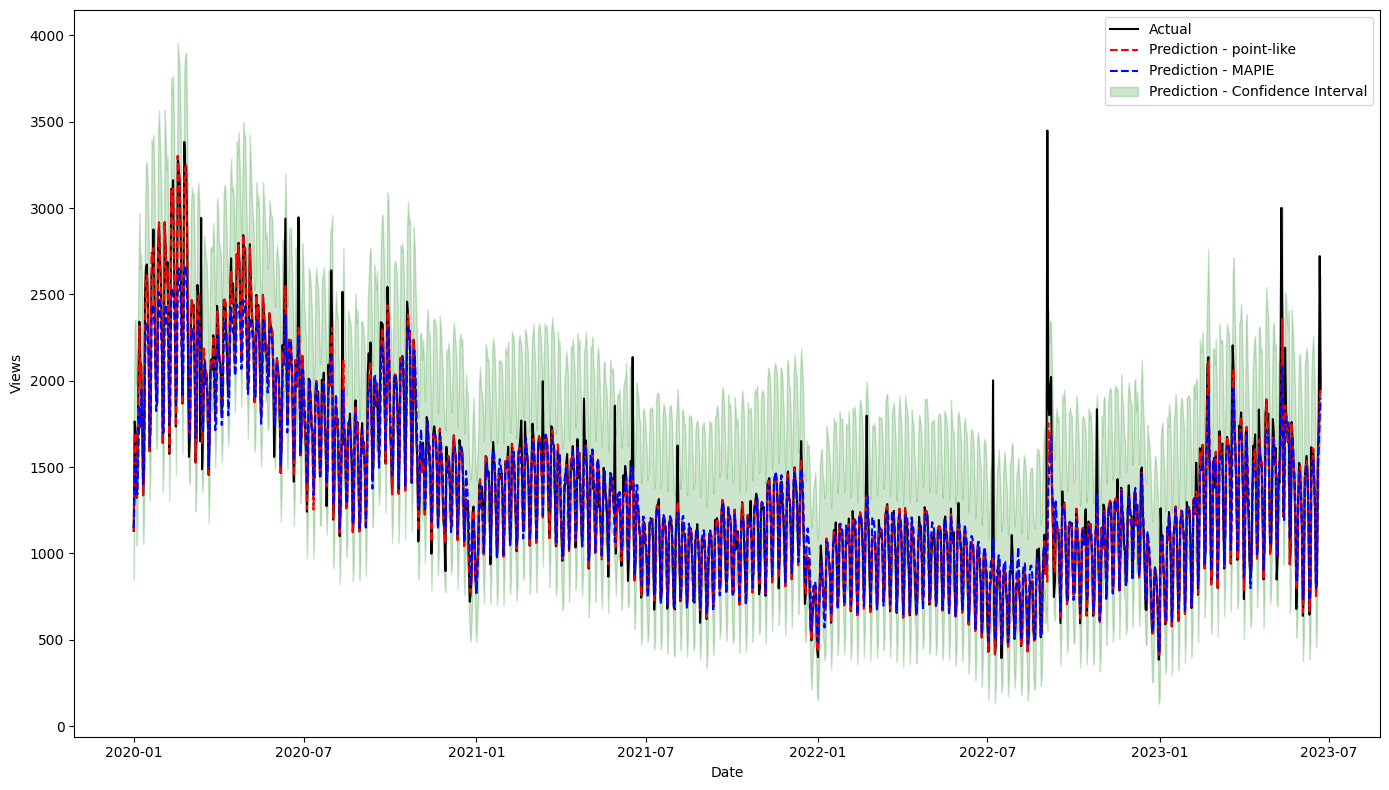

In [138]:
# compare them on a plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_train, label='Actual', color = "black")
ax.plot(y_train_pred_0, label='Prediction - point-like', ls='--', color="red")
ax.plot(y_train_pred, label='Prediction - MAPIE', ls='--', color="blue")
# fill the intervals
ax.fill_between(
    y_train.index, # index
    y_train_pred_interval[:, 0, 0], # lower bound
    y_train_pred_interval[:, 1, 0], # higher bound
    color='green',
    alpha=0.2,
    label = "Prediction - Confidence Interval",
)
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.legend(loc='best')
plt.tight_layout()

# Predict in test

In [139]:
# predict for the train sample
y_test_pred, y_test_pred_interval = mapie_enbpi.predict(
    X_test,
    alpha=alpha,
    ensemble=True,
    optimize_beta=True
)
y_test_pred, y_test_pred_interval

(array([1450.63810409, 1139.53975207, 1086.62153319, 1842.46660279,
        2300.78944282, 2131.63693222, 2164.17929424, 2055.59857632,
        1651.1280841 , 1438.75494627, 1836.08731988, 2090.23341079,
        1750.20610413, 1824.97130385, 1695.31206758, 1206.30253058,
        1171.61257365, 1517.20105738, 1845.05851943, 1675.73639632,
        1801.40308924, 1542.11112201,  991.67832692, 1101.06779352,
        1529.45860487, 1767.94494324, 1671.18239906, 1615.90678967,
        1443.54337792,  906.01522245,  929.82375561, 1433.70709005,
        1616.50101234, 1561.38247094, 1535.22878158, 1334.51203312,
         891.66483788,  865.45803601, 1311.13832367, 1456.89121772,
        1502.68046627, 1351.66096333, 1127.85253631,  743.85596564,
         773.13059783, 1373.5756415 , 1730.68649574, 1770.55270995,
        1549.49157999, 1488.5573456 ,  837.79714759,  875.12319381,
        1536.89232305, 1445.85918493, 1279.41674425, 1487.83053296,
        1254.54401067,  900.69774756,  951.49451

In [142]:
y_test_pred = pd.Series(y_test_pred, index=y_test.index)
y_test_pred

datetime
2023-06-23    1450.638104
2023-06-24    1139.539752
2023-06-25    1086.621533
2023-06-26    1842.466603
2023-06-27    2300.789443
                 ...     
2023-10-08     703.662563
2023-10-09    1148.056936
2023-10-10    1222.013772
2023-10-11    1387.725557
2023-10-12    1766.640051
Length: 112, dtype: float64

In [140]:
y_test_pred_interval[0][0][0]

1204.5765275282172

In [141]:
y_test_pred_interval[0][1][0]

2141.214338323942

In [143]:
# let's predict with the original model
y_test_pred_0 = model.predict(X_test)
y_test_pred_0 = pd.Series(y_test_pred_0, index=y_test.index)
y_test_pred_0

datetime
2023-06-23    1487.863250
2023-06-24    1196.387362
2023-06-25    1072.430636
2023-06-26    1982.477539
2023-06-27    2624.311189
                 ...     
2023-10-08     671.368174
2023-10-09    1190.714443
2023-10-10    1207.118547
2023-10-11    1310.169326
2023-10-12    2036.814244
Length: 112, dtype: float64

In [145]:
y_test

datetime
2023-06-23    1928
2023-06-24    1425
2023-06-25    2091
2023-06-26    3586
2023-06-27    2445
              ... 
2023-10-08     737
2023-10-09    1237
2023-10-10    1755
2023-10-11    3241
2023-10-12    2262
Name: y, Length: 112, dtype: int64

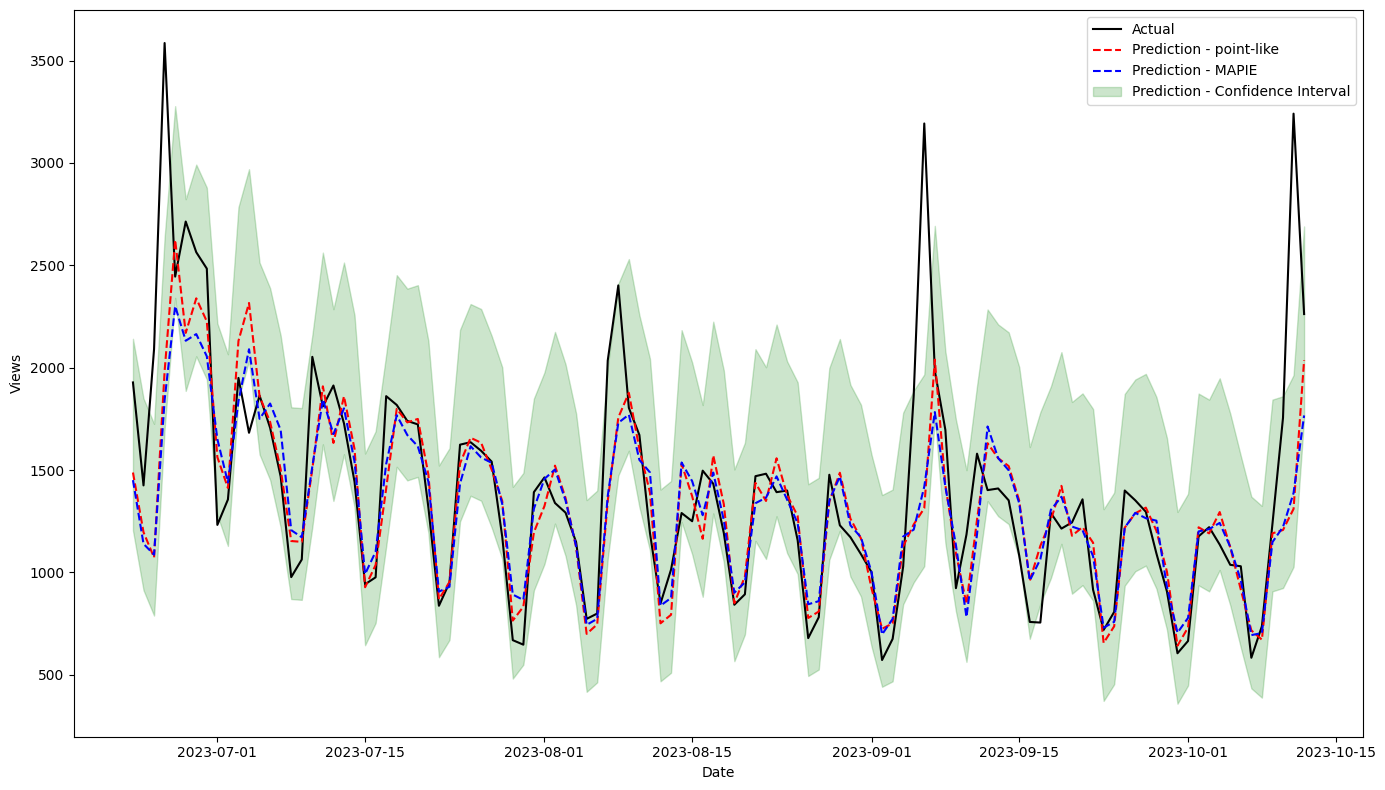

In [146]:
# compare them on a plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_test, label='Actual', color = "black")
ax.plot(y_test_pred_0, label='Prediction - point-like', ls='--', color="red")
ax.plot(y_test_pred, label='Prediction - MAPIE', ls='--', color="blue")
# fill the intervals
ax.fill_between(
    y_test.index, # index
    y_test_pred_interval[:, 0, 0], # lower bound
    y_test_pred_interval[:, 1, 0], # higher bound
    color='green',
    alpha=0.2,
    label = "Prediction - Confidence Interval",
)
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.legend(loc='best')
plt.tight_layout()

Some predicted values are outside the confience intervals, but it is expected as we asked for 95% conference.

Let's calculate the actual convergence and the mean interval width.

In [153]:
# Compute the coverage in train and test
# we aimed for 95% and we get 99% in train and 92% in test, but still acceptably close to 95%
coverage_train = regression_coverage_score(
    y_train, y_train_pred_interval[:, 0, 0], y_train_pred_interval[:, 1, 0]
)
coverage_test = regression_coverage_score(
    y_test, y_test_pred_interval[:, 0, 0], y_test_pred_interval[:, 1, 0]
)
coverage_train, coverage_test

(0.9905437352245863, 0.9285714285714286)

In [154]:
# Compute the width intervals in train and test
width_interval_train = regression_mean_width_score(
    y_train_pred_interval[:, 0, 0], y_train_pred_interval[:, 1, 0]
)
width_interval_test = regression_mean_width_score(
    y_test_pred_interval[:, 0, 0], y_test_pred_interval[:, 1, 0]
)
width_interval_train, width_interval_test

(936.6378107957246, 936.6378107957245)

# Conclusions

This is a hello world for forecasts predictions for time series with uncertainties.

* The procedure is relatively fast: original training about 30 seconds with cross validation, the second with MAPIE a few seconds
* The original (point-like) training and the central value of MAPIE training are very similar to each other, but not identical
* The confidence intervals respects quite well the requirement of 95%, with 99% for train and 92% for test
* The intervals are not symmetric around the point-like value, which is more realistic

